In [3]:
%matplotlib inline
import gym
import math
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from collections import deque
from IPython import display
from JSAnimation.IPython_display import display_animation
from matplotlib import animation
from scipy import stats
from training_methods import *
%load_ext autoreload
%autoreload

run_name = 0

## Action is added to input as OHE

In [17]:
class ActionAsInputAgent:
    def __init__(self, params):
        self.params = params
        self.memory = deque(maxlen=self.params.max_memory_size)
        self._build_model()
        
    def _build_model(self):
        input_len = self.params.state_size + self.params.action_size

        self.x = tf.placeholder("float", [None, input_len], name="Placeholder_x")
        self.y = tf.placeholder("float", [None, 1], name="Placeholder_y")

        h0 = tf.contrib.layers.fully_connected(
            inputs=self.x,
            num_outputs=20,
            activation_fn=tf.nn.relu,
            weights_initializer=tf.contrib.layers.xavier_initializer())
        
        self.pred = tf.contrib.layers.fully_connected(
            inputs=h0,
            num_outputs=1,
            activation_fn=None,
            weights_initializer=tf.contrib.layers.xavier_initializer())
        
        self.cost = tf.nn.l2_loss(self.pred - self.y)
        self.train_op = tf.train.RMSPropOptimizer(learning_rate=self.params.learning_rate, decay=0.99) \
            .minimize(self.cost)

    def remember(self, state, action, reward, next_state, frame):
        self.memory.append((state, action, reward, next_state, frame))

    def act(self, state, frame):
        if np.random.rand() <= self.params.epsilon:
            return np.random.randint(0, self.params.action_size)
        return self.act_greedy(state, frame)
    
    def act_greedy(self, state, frame):
        X = np.resize(state, (1, self.params.state_size + self.params.action_size))
        X[0, self.params.state_size:] = 0
        
        rewards = np.zeros((self.params.action_size))
        for i in range(self.params.action_size):
            X[0, self.params.state_size + i] = 1
            rewards[i] = session.run(self.pred, {self.x: X})[0]
            X[0, self.params.state_size + i] = 0
        return np.argmax(rewards)
    
    def think(self, batch_size, episode):
        cnt = len(self.memory)
        X = np.zeros((cnt, self.params.state_size + self.params.action_size))
        Y = np.zeros((cnt, 1))
        for i in range(cnt):
            state, action, reward, next_state, frame = self.memory[i]
            inp = np.resize(state, (self.params.state_size + self.params.action_size))
            inp[self.params.state_size:] = 0
            inp[self.params.state_size + action] = 1
            X[i], Y[i] = inp, reward

        P = np.random.permutation(cnt)
        for i in range(0, cnt, batch_size):
            batch_indexes = P[i: i + batch_size]
            batch_x = X[batch_indexes]
            batch_y = Y[batch_indexes]
            _ = session.run(self.train_op, {self.x: batch_x, self.y: batch_y})

## Policy Gradient

Run with `params.episodes_between_think = 1`

Karpathy: https://gist.github.com/karpathy/a4166c7fe253700972fcbc77e4ea32c5

TF interpretation: https://gist.github.com/greydanus/5036f784eec2036252e1990da21eda18

In [84]:
class PolicyGradientAgent:
    def __init__(self, params):
        self.params = params
        self.memory_states = []
        self.memory_actions = []
        self.memory_rewards = []
        self._build_model()

    def _build_model(self):
        self.x = tf.placeholder("float", [None, self.params.state_size], name='Placeholder_x')
        self.y = tf.placeholder("int32", [None], name='Placeholder_y')
        self.r = tf.placeholder("float", [None], name='Placeholder_r')

        # Pong:
#         x = tf.reshape(self.x, (tf.shape(self.x)[0], 19, 16, 4))
#         conv1 = tf.contrib.layers.conv2d(x, 16, 4, 2, activation_fn=tf.nn.relu)
#         flattened = tf.contrib.layers.flatten(conv1)

        # Breakout:
        x = tf.reshape(self.x, (tf.shape(self.x)[0], 80, 70, 4))
        conv1 = tf.contrib.layers.conv2d(x, 16, 8, 4, activation_fn=tf.nn.relu)
        conv2 = tf.contrib.layers.conv2d(conv1, 32, 4, 2, activation_fn=tf.nn.relu)
        flattened = tf.contrib.layers.flatten(conv2)

#         # Cartpole:
#         flattened = self.x

        fc1 = tf.contrib.layers.fully_connected(flattened, 128,
            activation_fn=tf.nn.relu,
            weights_initializer=tf.contrib.layers.xavier_initializer())
        
        fc2 = tf.contrib.layers.fully_connected(
            inputs=fc1,
            num_outputs=self.params.action_size,
            activation_fn=None,
            weights_initializer=tf.contrib.layers.xavier_initializer())
        
        self.pred = tf.nn.softmax(fc2)
        
        actions_ohe = tf.one_hot(self.y, depth=self.params.action_size)
        
        self.cost = tf.nn.l2_loss(self.pred - actions_ohe)

        optimizer = tf.train.RMSPropOptimizer(self.params.learning_rate_model, decay=0.99)
    
        gradients = optimizer.compute_gradients(
            self.cost,
            var_list=tf.trainable_variables(),
            grad_loss=tf.reshape(self.r, (tf.shape(self.r)[0], 1)))
        self.train_op = optimizer.apply_gradients(gradients)

    def remember(self, state, action, reward, next_state, frame):
        self.memory_states.append(state)
        self.memory_actions.append(action)
        self.memory_rewards.append(reward)

    def act(self, session, state, frame):
        if np.random.rand() <= self.params.epsilon:
            return np.random.randint(0, self.params.action_size)
        return self.act_greedy(session, state, frame)
    
    def act_greedy(self, session, state, frame):
        act_values = session.run(self.pred, feed_dict={self.x: [state]})[0]
        return np.random.choice(self.params.action_size, p=act_values)

    def think(self, session, batch_size, episode):
        cnt = len(self.memory_states)

        _ = session.run(self.train_op, {
            self.x: self.memory_states,
            self.y: self.memory_actions,
            self.r: self.memory_rewards})
        
        # It's on-policy algorithm
        self.memory_states = [] 
        self.memory_actions = []
        self.memory_rewards = []

## DQN Agent

In [91]:
class DqnAgent:
    def __init__(self, params):
        self.params = params
        self.memory_states = np.zeros((2 * self.params.max_memory_size, self.params.state_size))
        self.memory_next_states = np.zeros((2 * self.params.max_memory_size, self.params.state_size))
        self.memory_actions = np.zeros((2 * self.params.max_memory_size), dtype=np.int32)
        self.memory_rewards = np.zeros((2 * self.params.max_memory_size, 1))
        self.cnt = 0
        self._build_model()

    def _build_model(self):
        self.x = tf.placeholder("float", [None, self.params.state_size], name="Placeholder_x")
        self.y = tf.placeholder("float", [None, self.params.action_size], name="Placeholder_y")

        # Pong:
#         x = tf.reshape(self.x, (tf.shape(self.x)[0], 19, 16, 4))
#         conv1 = tf.contrib.layers.conv2d(x, 16, 4, 2, activation_fn=tf.nn.relu)
#         flattened = tf.contrib.layers.flatten(conv1)

        # Breakout:
        x = tf.reshape(self.x, (tf.shape(self.x)[0], 80, 70, 4))
        conv1 = tf.contrib.layers.conv2d(x, 16, 8, 4, activation_fn=tf.nn.relu)
        conv2 = tf.contrib.layers.conv2d(conv1, 32, 4, 2, activation_fn=tf.nn.relu)
        flattened = tf.contrib.layers.flatten(conv2)

        # Cartpole:
#         flattened = self.x

        fc1 = tf.contrib.layers.fully_connected(flattened, 128,
            activation_fn=tf.nn.relu,
            weights_initializer=tf.contrib.layers.xavier_initializer())
        
        self.pred = tf.contrib.layers.fully_connected(
            inputs=fc1,
            num_outputs=self.params.action_size,
            activation_fn=None,
            weights_initializer=tf.contrib.layers.xavier_initializer())
        
#         self.cost = tf.nn.l2_loss(self.pred - self.y)
        self.losses = tf.squared_difference(self.pred, self.y)
        self.cost = tf.reduce_mean(self.losses)

        self.train_op = tf.train.RMSPropOptimizer(learning_rate=self.params.learning_rate, decay=0.99) \
            .minimize(self.cost)
#         train_op = tf.train.AdamOptimizer(learning_rate=self.params.learning_rate_model).minimize(cost)

    def remember(self, state, action, reward, next_state, frame):
        self.memory_states[self.cnt] = state
        self.memory_next_states[self.cnt] = next_state
        self.memory_actions[self.cnt] = action
        self.memory_rewards[self.cnt] = reward
        self.cnt += 1
        
        if self.cnt == 2 * self.params.max_memory_size:
            n = self.params.max_memory_size
            self.memory_states[:n] = self.memory_states[-n:]
            self.memory_next_states[:n] = self.memory_next_states[-n:]
            self.memory_actions[:n] = self.memory_actions[-n:]
            self.memory_rewards[:n] = self.memory_rewards[-n:]
            self.cnt = n

    def act(self, session, state, frame):
        if np.random.rand() <= self.params.epsilon / 10:  # Reduce exploration
            return np.random.randint(0, self.params.action_size)
        return self.act_greedy(session, state, frame)
    
    def act_greedy(self, session, state, frame):
        act_values = session.run(self.pred, {self.x: [state]})[0]
        return np.argmax(act_values)

    def think(self, session, batch_size, episode):
        if self.cnt < 2000:
            return
        
        cnt = self.cnt
        
        values = session.run(self.pred, {self.x: self.memory_states[:cnt]})
        nextValues = session.run(self.pred, {self.x: self.memory_next_states[:cnt]})
        
        values[np.arange(cnt), self.memory_actions[:cnt]] = \
            self.memory_rewards[:cnt, 0] + self.params.gamma * np.amax(nextValues, axis=1)

        P = np.random.permutation(cnt)
        for i in range(0, cnt, batch_size):
            batch_indexes = P[i: i + batch_size]
            batch_x = self.memory_states[batch_indexes]
            batch_y = values[batch_indexes]
            _ = session.run(self.train_op, {self.x: batch_x, self.y: batch_y})

In [67]:
# env = gym.make('CartPole-v1')
# env_state_observer = EnvStateObserver(lambda x: x, concat_states_count=3)

# env = gym.make('Pong-v0')
# env_state_observer = EnvStateObserver(preprocess_input_pong_v0, concat_states_count=4)

env = gym.envs.make("Breakout-v0")
env_state_observer = EnvStateObserver(preprocess_input_breakout_v0, concat_states_count=4)

# env.render(close=True)
# plt.imshow(env.render('rgb_array'))
sample_state = env_state_observer.env_reset(env)
print('Actions: {}'.format(env.action_space.n))
print('Raw observation space: {}'.format(env.observation_space.shape))
print('Max episode steps: {}'.format(env.spec.max_episode_steps))
print('Preprocessed observation space: {}'.format(sample_state.shape))
print('Parameters: {}'.format(np.prod(sample_state.shape)))

[2017-09-03 14:42:56,027] Making new env: Breakout-v0


Actions: 4
Raw observation space: (210, 160, 3)
Max episode steps: 10000
Preprocessed observation space: (22400,)
Parameters: 22400


((22400,), 0.0)


count    22400.000000
mean         0.000071
std          1.000572
min         -0.526482
25%         -0.526482
50%         -0.526482
75%         -0.526482
max          2.319368
dtype: float64

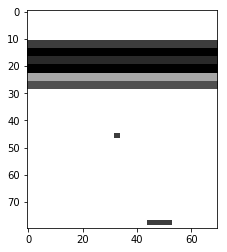

In [52]:
state = env_state_observer.env_reset(env)
state, reward, next_state, done = env_state_observer.env_step(env, 1)
print(state.shape, reward)
plt.imshow(state.reshape((80, 70, 4))[:,:,3], cmap='Greys')
pd.Series(state).describe()

State shape (22400,), actions 4
Loading model checkpoint logs/PolicyGradientAgent/checkpoints/model...

INFO:tensorflow:Restoring parameters from logs/PolicyGradientAgent/checkpoints/model


[2017-09-03 21:19:19,528] Restoring parameters from logs/PolicyGradientAgent/checkpoints/model


episode: 5000/100000, reward 1.3, frames 174, exploration rate: 0.86
episode: 10000/100000, reward 0.9, frames 164, exploration rate: 0.74
episode: 15000/100000, reward 1.3, frames 225, exploration rate: 0.64
episode: 20000/100000, reward 1.3, frames 354, exploration rate: 0.55
episode: 25000/100000, reward 0.7, frames 169, exploration rate: 0.47
episode: 30000/100000, reward 1.4, frames 201, exploration rate: 0.41
episode: 35000/100000, reward 1.1, frames 284, exploration rate: 0.35
episode: 40000/100000, reward 1.1, frames 206, exploration rate: 0.3
episode: 45000/100000, reward 1.8, frames 301, exploration rate: 0.26
episode: 50000/100000, reward 1.2, frames 259, exploration rate: 0.22
episode: 55000/100000, reward 2.0, frames 229, exploration rate: 0.19
episode: 60000/100000, reward 1.3, frames 161, exploration rate: 0.17
episode: 65000/100000, reward 0.3, frames 162, exploration rate: 0.14
episode: 70000/100000, reward 0.6, frames 201, exploration rate: 0.12
episode: 75000/100000,

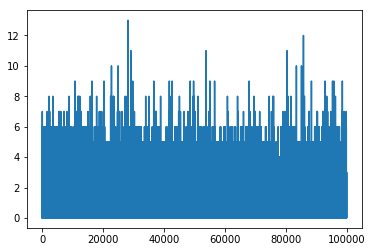

In [108]:
tf.reset_default_graph()

params = LearningParameters(env, env_state_observer.env_reset(env), episodes_count=100000)
params.max_frame_in_episode = min(params.max_frame_in_episode, 500)
params.epsilon_min = 0.05
params.max_memory_size = 2000
params.pong_reset_discounted_reward = False
agent = PolicyGradientAgent(params)
# agent = DqnAgent(params)
# agent = ActionAsInputAgent(params)

saver = TfSaver('logs/' + agent.__class__.__name__)

# Train on GPU
config = tf.ConfigProto(log_device_placement=True)
config.gpu_options.per_process_gpu_memory_fraction=0.7
config.operation_timeout_in_ms=60000

# Train on CPU
# config = tf.ConfigProto(device_count = {'GPU': 0})

with tf.Session(config=config) as session:
    session.run(tf.global_variables_initializer())

    saver.load_latest_checkpoint(session)
    
#     tf_writer = tf.summary.FileWriter('logs/run' + str(run_name), session.graph)

    agent, rewards = train_discounted_rewards(session, saver, env, agent, env_state_observer, params,
                                              normalize_rewards=True)
    # agent, rewards = train_reward_is_time(env, agent, params)
    # agent, rewards = train(env, agent, params)
    plt.plot(rewards)

In [116]:
with tf.Session(config=config) as session:
    session.run(tf.global_variables_initializer())
    evaluate(session, env, agent, env_state_observer, params, 500)

Total reward: 1.0


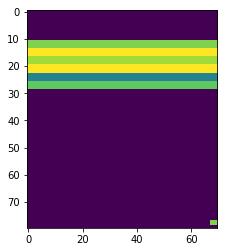

In [118]:
with tf.Session(config=config) as session:
    session.run(tf.global_variables_initializer())
    show(session, env, agent, env_state_observer, params, 200, width=80, height=70, greedy=True)

In [ ]:
# Save rewards/model
pd.DataFrame(rewards).to_csv('models/rewards_40K_50K.csv', header=None)
saver = tf.train.Saver()
saver.save(session, 'models/Pong PolicyGradient', global_step=50000)